# 7. 인물사진을 만들어 보자

## 7-2. 셸로우 포커스 만들기 (1) 사진을 준비하자

In [1]:
import os
import urllib # urllib은 웹에서 데이터를 다운로드 할때 이용한다
import cv2    # OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import numpy as np
from pixellib.semantic import semantic_segmentation # 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

print('슝=3')

슝=3


(886, 886, 3)


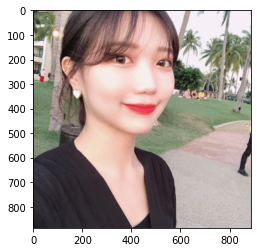

In [2]:
# 준비한 이미지 불러오기 
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpeg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 7-3. 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기

- 이미지와 피사체를 분리한다
- 누끼 따기

세그멘테이션(Segmentation)이란?
- 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법

시맨틱 세그멘테이션(semantic segmentation)이란?
- 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법
- 사람이 누구인지 관계없이 같은 라벨로 표현

인스턴스 세그멘테이션(Instance segmentation)이란?
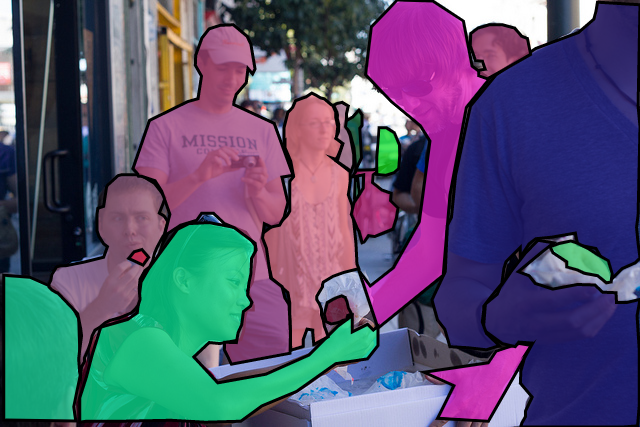
- '사람'이라는 추상적인 정보를 이미지에서 추출
- 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨

딥러닝에 기반한 방법 이전에는 어떻게 사람을 분리?
- grayscale(0~255)의 값으로 변환해서 픽셀값으로 분리했음

## 7-4. 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기

- DeepLab이라는 세그멘테이션 모델 이용

DeepLab에서 atrous convolution을 사용한 이유?
- 파라미터 수를 늘리지 않으면서도 receptive field를 크게 키울 수 있기 때문에

In [3]:
# PixelLib에서 제공해 주는 모델 다운로드

# 저장할 파일 이름 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드 ㄱㄱ
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f36a05d0400>)

In [4]:
# 다운받은 모델로 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [5]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path) # PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미

In [6]:
# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- background를 제외하면 20개의 클래스
- 20 = tv
- 이 중 사람(person)라벨인 15만 추출하자

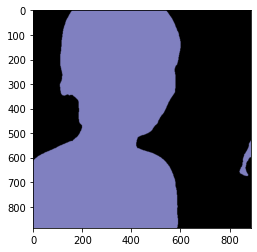

In [7]:
plt.imshow(output) # output = 모델에서 나온 출력값
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

- output = 세그멘테이션이 된 결과가 각각 다른 색상으로 담김
- segvalues = class_ids, masks
- class_ids를 통해 어떤 물체가 있는지 확인 가능

이제 물체마다 output에 어떤 색상으로 나타나 있는지만 알아내자

In [9]:
# PixelLib에서 그대로 가져온 코드, 주목해야 할 것은 생상 코드 결과물

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

- PixelLib에 있는 각각 물체의 색상 값들 

In [10]:
# 사람을 나타내는 15번째 색상
colormap[15]

array([192, 128, 128])

- 문제점 : output 이미지가 BGR 순서
- colormap은 RGB 순서, 바꿔줘야 한다

In [11]:
# 컬러맵 순서 바꾸기
seg_color = (128,128,192)

이제 seg_color로만 이루어진 마스크를 만들자

(886, 886)


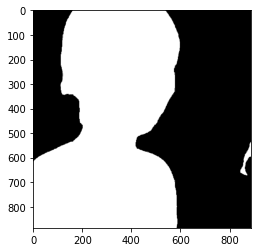

In [12]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

3채널을 가졌던 원본과 다르게 채널 정보가 사라짐

이제 아래처럼 물체가 있는 위치는 1(True), 그 외에는 0(False)
[
[ 0 1 1 0 0 0 1 1 0 ],
[ 1 1 1 1 0 1 1 1 1 ],
[ 0 1 1 1 1 1 1 1 0 ],
[ 0 0 1 1 1 1 1 0 0 ],
[ 0 0 0 1 1 1 0 0 0 ]
]

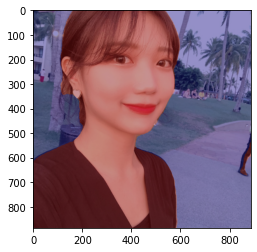

In [13]:
# 원래 이미지와 겹쳐 보며 비교해보자
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 변경
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합친다
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 7-5. 셸로우 포커스 만들기 (4) 배경 흐리게 하기

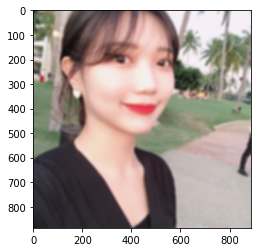

In [14]:
# blur() 함수로 배경 흐리게 만들기

img_orig_blur = cv2.blur(img_orig, (13,13))  # (13,13) = blurring kernel size
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

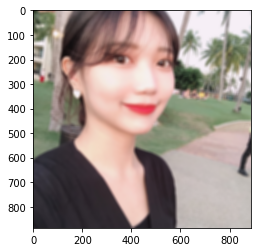

In [15]:
img_orig_blur = cv2.blur(img_orig, (14,14))  # 14로 바꾸니까 더 흐려짐
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

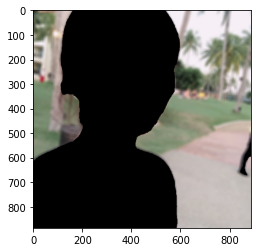

In [16]:
# 흐려진 이미지에서 세그멘테이션 마스크로 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- bitwise_not 함수로 이미지 반전
- 원래 마스크에서 배경이 0, 사람이 255 -> bitwise_not이후 배경은 255, 사람은 0

반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있다
0과 어떤 수를 bitwise_and를 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됨

## 7-6. 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성
배경이랑 사람을 합치면 끝!

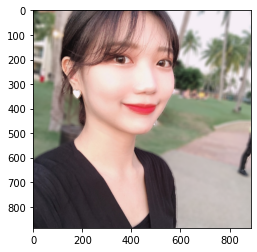

In [17]:
img_concat_1 = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat_1, cv2.COLOR_BGR2RGB))
plt.show()

# 7-7. 프로젝트: 인물 모드 문제점 찾기


## Step 1. 인물모드 직접 해 보기 

### 셀카는 앞서 해봤으니 고양이 대신 강아지로 해서 셸로우 포커스 만들기
친구집 강아지 사진이 있길래 가져왔당

(750, 750, 3)


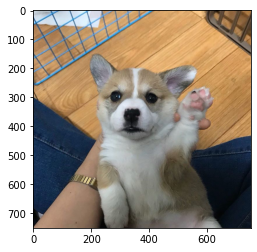

In [18]:
# 강아지 이미지 불러오기 
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_dog.jpeg'  
img_orig = cv2.imread(img_path)

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path) # PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미

# PASCAL VOC 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', # dog = 12
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

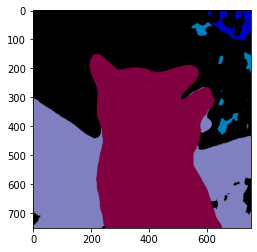

In [20]:
plt.imshow(output) # output = 모델에서 나온 출력값
plt.show()

In [21]:
segvalues

{'class_ids': array([ 0,  9, 11, 12, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True],
        [False,  True,  True, ...,  True,  True,  True]])}

In [22]:
# dog인 12를 넣어봤다
colormap[12]

array([ 64,   0, 128])

In [23]:
# 컬러맵 순서 바꾸기
seg_color = (128,0,64)

(750, 750)


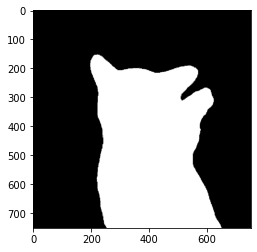

In [24]:
#seg_color로만 이루어진 컬러맵
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

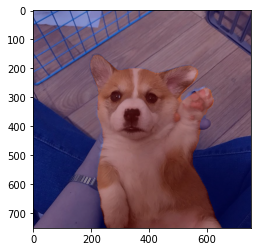

In [25]:
# 원래 이미지와 겹쳐 보며 비교해보자
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 변경
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합친다
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

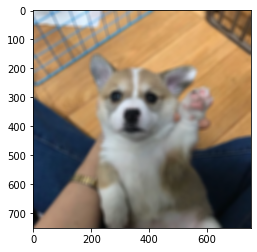

In [26]:
# blur() 함수로 배경 흐리게 만들기

img_orig_blur = cv2.blur(img_orig, (15,15))  # blurring kernel size 변경
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

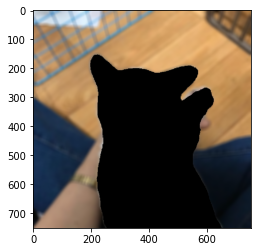

In [27]:
# 흐려진 이미지에서 세그멘테이션 마스크로 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

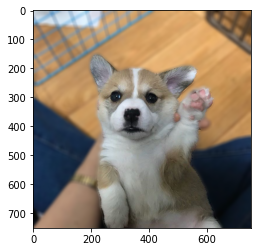

In [28]:
# 배경과 사람을 합치면 끝!오봉아 안뇽

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 배경전환 크로마키 사진을 만들어보자

(460, 690, 3)


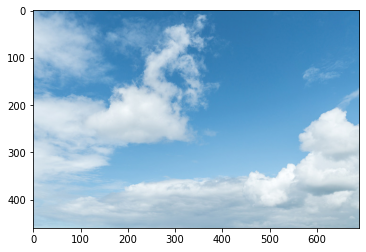

In [29]:
# 배경사진 이미지 불러오기 (사진은 구글링으로 찾음)
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpeg'  
img_bg = cv2.imread(img_path)
print(img_bg.shape)
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
plt.show()

배경사진 이미지를 맞춰주자
(460,690,3) -> (750,750,3)

In [30]:
img_bg = cv2.resize(img_bg, dsize=(750, 750), interpolation=cv2.INTER_AREA)
print(img_bg.shape)

(750, 750, 3)


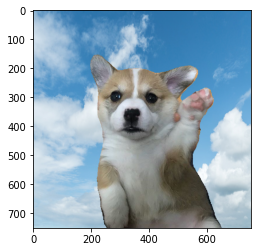

In [31]:
# 배경이랑 마스크 합쳐주면 꿑! 
img_concat = np.where(img_mask_color==255, img_orig, img_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Step 2. 사진에서 문제점 찾기

In [32]:
import matplotlib.image as mpimg

img_dir = os.getenv('HOME') + '/aiffel/human_segmentation/images'
img1 = mpimg.imread(img_dir + '/pb1.png')
img2 = mpimg.imread(img_dir + '/pb3.png')
img3 = mpimg.imread(img_dir + '/pb2.png')

### problem 1. 사람 다리가 일부 인식됨

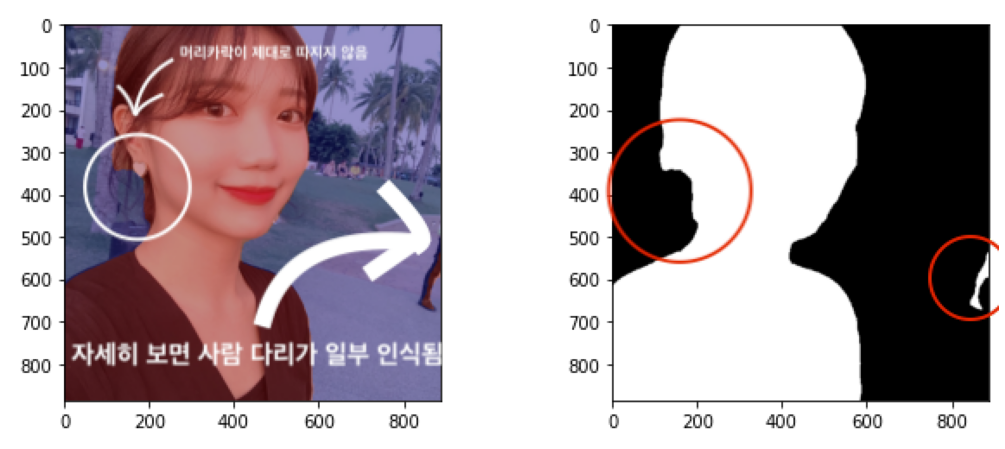

In [33]:
import matplotlib.image as mpimg

img_dir = os.getenv('HOME') + '/aiffel/human_segmentation/images'

fig = plt.figure(figsize = (18, 8))
rows = 1
cols = 2

ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(img1)
ax1.axis("off")

ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(img2)
ax2.axis("off")

plt.show()

- 사진에 우연히 걸린 지나가던 사람의 다리가 인식되었다.
- 그리고 머리카락들이 제대로 인식되지 않았다.

### problem 2. 영역이 매끄럽게 처리되지 않음

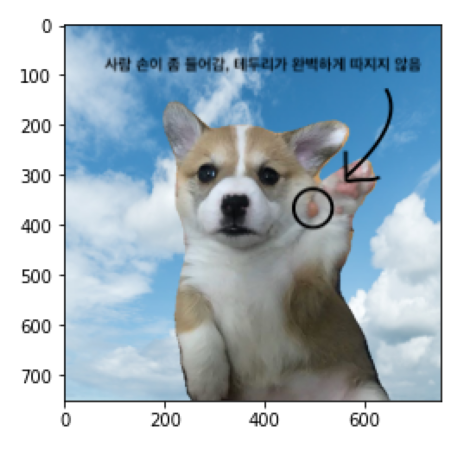

In [34]:
fig = plt.figure(figsize = (8,8))
plt.imshow(img3)
plt.axis("off")
plt.show()

- 사람의 손이 인식되었다.
- 물체의 영역이 완전 매끄럽지는 않다.

## Step 3. 해결 방법을 제안해 보기